# Using Transfer Learning to predict ratings on Yelp reviews.

###### Transfer learning is a technique which is used when we want to apply deep learning methods to our model and instead of training a model from scratch, we reuse a pre-trained model and then fine-tune it for our task. We will be using Language Model to build a text classifier using fast.ai library.


### Language Model
####  A language model attempts to learn the structure of the text through hierarchical representations, and thus contains both low-level features (word representations) and high-level features (semantic meaning). A key feature of language modelling is that it is generative, meaning that it aims to predict the next word given a previous sequence of words. Here is an an example: 
“I’d like to eat a hot ___”: Obviously, “dog”, right?  

“It was a hot ___”: Probably “day”

## Setting up enviroment

In [0]:
!pip install http://download.pytorch.org/whl/cpu/torch-1.0.0-cp36-cp36m-linux_x86_64.whl


     |████████████████████████████████| 69.4MB 21.0MB/s 
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 1.0.0 which is incompatible.
  Found existing installation: torch 1.3.0+cu100
    Uninstalling torch-1.3.0+cu100:
      Successfully uninstalled torch-1.3.0+cu100


In [0]:
 !pip install fastai


In [0]:
from fastai.text import *

## 0 - Loading the data

In [0]:
#Rating_prediction
from google.colab import files
uploaded = files.upload()

Saving rating_prediction_subset.csv to rating_prediction_subset.csv


In [0]:
import io
import pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['rating_prediction_subset.csv']))



In [0]:
df.head()

,stars,text
0,1,Total bill for this horrible service? Over $8G...
1,5,If you are looking for the best pierogies in P...
2,1,Met a friend for dinner there tonight. The ser...
3,4,So good! They didn't make it to 5 stars due to...
4,1,They charged me twice what I expected to pay. ...


In [0]:
trn_texts = df.loc[:20000, 'review'].values
trn_labels = df.loc[:20000, 'sentiment'].values
val_texts = df.loc[20000: ,'review'].values
val_labels = df.loc[20000: ,'sentiment'].values


## Steps: 

1.   Data pre-processing 
2.   Create a language model
3.   Create classifier model



## 1 - Data Pre-processing

In [0]:
import numpy as np
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

col_names = ['labels','text']
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

#### We'll create data class: TextDataBunch for text preprocessing. This does all the necessary preprocessing behind the scene

In [0]:
data_lm = TextLMDataBunch.from_df('./', train_df=df_trn, valid_df=df_val)

In [0]:
data_lm.show_batch()

idx,text
0,been a regular here since you opened . xxmaj chef xxmaj jose is a sweetheart still & i know if i went back to find him he 'd find me a nice seat & make the experience special . \n \n xxmaj the xxup gm xxmaj roy had zero to say as well when i mentioned this to him . xxmaj wow . a friend of mine was in
1,xxmaj plenty of xxunk kept me typing away for hours . xxmaj the free wifi is also incredibly consistent and reliable . xxmaj pull up a chair by the window and you can gaze out at street traffic in old xxup mtl . xxmaj thank you xxmaj thé xxmaj mon and xxmaj yelp for leading me here ! xxbos xxmaj our office did a xxmaj chinese take out day from
2,"and did n't mind a larger bill . xxbos i recently was sent a package from amazon using my xxmaj prime membership . xxmaj they sent it via ontrac ... hmm never heard of them they must be a local delivery xxunk new to the area ) . \n xxmaj tracking said the package was delivered , but i never found anything . xxmaj the driver was supposed to"
3,"milkshakes are superior to xxmaj in & xxmaj out for the reason that they offer various flavors and all are yummy . xxmaj in addition , the cookies here are so delicious they probably have xxunk in the back baking these in small batches . \n \n xxmaj american food was never represented in a better light . i love this place and i hope they continue to grow"
4,my driver 's side rear window . xxmaj it looked like a bullet hole but it was so tiny it had to have been a bb pellet ( xxmaj frickin ' a - hole kids in my neighborhood probably ) . xxmaj anyways ... i called xxmaj geico yesterday and they got me an appointment window with xxmaj safelite for xxunk on 9 - 15 - 15 . \n \n


#### We can see a number of tags are applied to words as shown above. This is to retain all the information which can be used to gather an understanding of the new task’s vocabulary.


* **xxup:** If there's something in all caps, it gets lower cased and a token called xxup will get added to it. Words that are fully capitalized, such as “I AM SHOUTING”, are tokenized as “xxup i xxup am xxup shouting“
* **xxunk:** token used instead of an uncommon word.
* **xxmaj:** token indicates that there is capitalization of the word. “The” will be tokenized as “xxmaj the“.
* **xxrep:** token indicates repeated word, if you have 29 ! in a row, (i.e. xxrep 29 !).



In [0]:
# save and load
data_lm.save('tmp_lm')
#data_lm = TextClasDataBunch.load('tmp_lm')

## 2 - Language Model

#### Fast.ai has a pre-trained Wikitext model, consisting of a pre-processed subset of 103 million tokens extracted from Wikipedia.

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

### How to fine tune the pre trained model on our data?
#### Learning rate hyper-parameter is one of the most important parameters to train a model. Fast.ai provides a convenient utility (learn.lr_find) to search through a range of learning rates to find the optimum one for our dataset. 

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


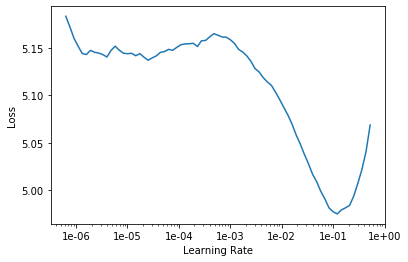

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.049410,3.929072,0.275757,05:32


##### Here we are training only last layers with just one epoch and our accuracy is ~27%. Now let's train the enitre model.

In [0]:
learn.save('fit_head')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.707701,3.744890,0.298351,06:34


In [0]:
learn.save('fine_tuned');

##### Predicting the Language Model

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS) for _ in range(N_SENTENCES)))

I liked this movie because of the great people - who are so care about the people that know that you should . You can even imagine the same kind of highlight and appearance . 
 
  We had some fun to see them
I liked this movie because it was delicious . 
 
  The food was delicious and the service was very professional and we were able to keep our reservation at until late noon . 
 
  We ordered the fried chicken , the chicken wings


In [0]:
learn.save_encoder('fine_tuned_enc')

## 3 - Classifier Model

#### Step one, is to create a data bunch, TextClasDataBunch, passing the vocab from the language model to make sure that this data bunch is going to have exactly the same vocab.

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_df('./', train_df=df_trn, valid_df=df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
data_clas.save('data_clas.pkl')

#### Next, we will create a text classifier learner. Load in our pre train model, the encoding part we saved earlier ‘fine_enc’.

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

#### And we follow the same method to find the learning rate and train the model

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


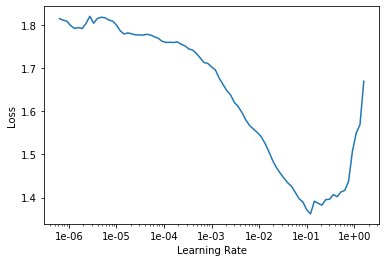

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.863798,0.803689,0.663600,03:29


In [0]:
learn.save('first')
learn.load('first');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
learn.save('second')

epoch,train_loss,valid_loss,accuracy,time
0,0.819054,0.740967,0.689700,04:22


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.381793,0.781675,0.714900,07:30
1,0.348103,0.804387,0.715300,06:59


## Testing the model performance

In [0]:
learn.predict("worst pizza ever!!!!")

(Category 1, tensor(0), tensor([0.9480, 0.0040, 0.0017, 0.0030, 0.0433]))

In [0]:
learn.predict("if you are a taco lover, do visit this cafe, best tacos in town")

(Category 5, tensor(4), tensor([0.0369, 0.0012, 0.0022, 0.0442, 0.9155]))

In [0]:
learn.predict("food was good")

(Category 3, tensor(2), tensor([0.0257, 0.0917, 0.3232, 0.2975, 0.2618]))

In [0]:
learn.predict("worst pizza ever!!!!")

(Category 1, tensor(0), tensor([0.9480, 0.0040, 0.0017, 0.0030, 0.0433]))

**Let's try on real reviews posted on Yelp and compare with model predictions**

In [0]:

learn.predict("This is my #1 place to get pad thai. I love pad thai and I've been in search of a place for years that can compare.\
 Atmosphere is really nice, great place to go with friends. There's always a line-up to get in, so you know it's good. \
 Food: Deeelicous!\
 I think this is probably the best place in the city to get Thai.\
 if you disagree with me please tell me what compares cuz I'd love to try! haha.")

(Category 5, tensor(4), tensor([0.0369, 0.0012, 0.0022, 0.0442, 0.9155]))

![title](1.jpg)

In [0]:
learn.predict("This place is good solid choice of upscale Japanese food, but jaBistro just didn't hit the right high notes for me\
and the Mr. enough to make us go WOW.\
I think part of the reason is because we went in with high expectations.\
Unfortunately, the menu and execution wasn't enough to make me put this back on my Special Occasion list.\
The service was excellent and attentive, so I will give them those points.\
We ordered their Aburi sampler, in addition to their tasting menu. To maximize your experience here, don't order the tasting menu\
as most of the stuff\
is not exceptional/memorable.\ I would go a la carte and check their daily special; in terms of the aburi style rolls, I would say\
order the JaBistro roll as it was the best of all the other offerings.\
Overall: pretty good, but not exceptional.")

(Category 3, tensor(2), tensor([0.0257, 0.0917, 0.3232, 0.2975, 0.2618]))

![title](2.jpg)